In [2]:
import requests
import bs4
from bs4 import BeautifulSoup
import csv
import time
import datetime

baseurl = 'http://www.atpworldtour.com'
topplayers = "http://www.atpworldtour.com/en/performance-zone/win-loss-index/career/all/all/"
xd = "http://www.atpworldtour.com/en/scores/results-archive"
#topplayers = baseurl + "/en/content/ajax/fedex-performance-full-table/career/All/All"
soup = BeautifulSoup(requests.get(xd).text.encode('utf-8'),'lxml')
soup

<!DOCTYPE html>
<!-- START : /modules/global/head --><!--[if lt IE 7]>
    <html class="no-js lt-ie10 lt-ie9 lt-ie8 lt-ie7 ">
<![endif]--><!--[if IE 7]>
    <html class="no-js lt-ie10 lt-ie9 lt-ie8 ">
<![endif]--><!--[if IE 8]>
    <html class="no-js lt-ie10 lt-ie9 ">
<![endif]--><!--[if IE 9]>
    <html class="no-js lt-ie10 ">
<![endif]--><!--[if gt IE 9]><!--><html class="no-js ">
<!--<![endif]-->
<head>
<!-- disable auto format for telephone numbers -->
<meta content="telephone=no" name="format-detection"/>
<title>
	Results Archive | ATP World Tour | Tennis
</title>
<meta content="initial-scale=1.0, width=768, user-scalable=yes, minimum-scale=1.0, maximum-scale=1.25" name="viewport"/>
<meta charset="utf-8"/>
<meta content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
<meta content="" name="keywords"/>
<meta content="" name="description"/>
<meta content="SKYPE_TOOLBAR_PARSER_COMPATIBLE" name="SKYPE_TOOLBAR"/>
<meta content="" name="thumbnail"/>
<meta content="Results Archive" pro

In [14]:
soup.find_all('div', class_='item-details')[1].get_text()

'\r\nOutdoor \t\t\t\t\t\t\r\n\t\t\t\t\r\n\t\t\t\t\tHard\r\n\t\t\t\t\n'

In [7]:
### Clustering
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_excel("2016.xlsx")

In [8]:
### get data in the form of players - court type - total wins on that court type
courtdf = df[['Court','Surface','Winner','Loser','W1','L1','W2','L2','W3','L3']].copy()
winnercourt = df[['Court','Surface','Winner','W1','W2','W3']].copy()
losercourt = df[['Court','Surface','Loser','L1','L2','L3']]
playercourt = winnercourt.groupby(['Winner','Court','Surface']).sum().reset_index()
playercourt = playercourt.fillna(0)
playercourt['W1'] = playercourt['W1'] + playercourt['W2'] + playercourt['W3']
del playercourt['W2']
del playercourt['W3']
playercourt.columns = ['Player','Court','Surface','Score']
losercourt = losercourt.groupby(['Loser','Court','Surface']).sum().reset_index()
losercourt = losercourt.fillna(0)
losercourt['L1'] = losercourt['L1'] + losercourt['L2'] + losercourt['L3']
del losercourt['L2']
del losercourt['L3']
losercourt.columns = ['Player','Court','Surface','Score']
playercourt = pd.concat([playercourt,losercourt]).groupby(['Player','Court','Surface'], as_index=False)['Score'].sum()

In [9]:
### Identify the number of court types played in a tournament year, to normalize the data to

In [10]:
courtdf = pd.DataFrame({'Player':'d','Indoor':'j','Outdoor':'j','Hard':'j','Clay':'j','Grass':'j','Score':'s'},index=[0])
cols = courtdf.columns.tolist()
cols = [cols[-2]] + cols[:-4] + cols[-4:-2] + [cols[-1]]
courtdf = courtdf[cols]
li = np.zeros(shape=(1,6))
players = []
for index,row in playercourt.iterrows():
    tmp_list=np.zeros(shape=(1,6))
    players.append(row['Player'])
    tmp_list[0][-1] = row['Score']
    if row['Court'] == 'Outdoor':
        tmp_list[0][-2] = 1
    else:
        tmp_list[0][-3] = 1
        
    if row['Surface'] == 'Grass':
        tmp_list[0][2] = 1
    elif row['Surface'] == 'Hard':
        tmp_list[0][3] = 1
    elif row['Surface'] == 'Clay':
        tmp_list[0][1] = 1
    li = np.append(li,tmp_list,axis=0)
li = np.delete(li,0,0)

In [11]:
courtdf = pd.DataFrame(players)
courtdf = pd.concat([courtdf,pd.DataFrame(li)], axis=1)
courtdf.columns = ['Players','Clay','Grass','Hard','Indoor','Outdoor','Score']

In [12]:
import sklearn.metrics as metrics

def silkmeans(data):
    s = np.zeros(20)
    for k in range(2,20):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(data)
        s[k] = metrics.silhouette_score(data,kmeans.labels_,metric='euclidean')
    plt.plot(range(1,len(s)),s[1:])
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')

In [13]:
arraypt1 = np.zeros(len(courtdf.columns))
for index, row in courtdf.iterrows():
    arraypt1 = np.vstack(((np.asarray(row)),arraypt1))
arraypt1 = np.delete(arraypt1, -1, axis=0) # array of 0's
arraypt2 = arraypt1
n = 0
for elem in set(arraypt1[:,0]):
    ind = np.where(arraypt1==elem)[0]
    for elem2 in ind:
        arraypt2[elem2][0] = n
    n += 1
# new array with names as numbers

scalednonames = arraypt2*[100,1,1,1,1,1,1] # need proper scaling with weights determined by court type frequency of appearance.
#silkmeans(scalednonames)

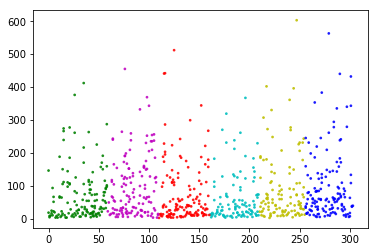

In [14]:
kmeans = KMeans(init='k-means++', n_clusters=6, n_init=100)
kmeans1 = kmeans.fit_predict(scalednonames)
colors = ['bgrcmykbgrcmykbg'[p] for p in kmeans1]

centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

plt.scatter(arraypt2[:,0], arraypt2[:,-1], c=colors, s=3, alpha=0.8)

array([[0, 0.0, 0.0, ..., 0.0, 0.0, 2.0],
       [0.0, 0.0, 0.0, ..., 0.0, 1, 2.0],
       [0.0, 0.0, 0.0, ..., 0.0, 1, 3.0],
       ..., 
       [0.0, 1.0, 1.0, ..., 1.0, 303, 512.0],
       [0.0, 1.0, 1.0, ..., 1.0, 303, 563.0],
       [0.0, 1.0, 1.0, ..., 1.0, 303, 603.0]], dtype=object)

In [195]:
t

array([False, False, False, False,  True,  True, False,  True, False,
       False, False, False, False, False, False, False], dtype=bool)